# Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [21]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import warnings 
warnings.filterwarnings(action='ignore')

In [22]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


In [23]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
# Grid Search
BATCH_SIZE = 32
EPOCHS = 5

# Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [24]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [25]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [26]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [27]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [28]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [29]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [30]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [31]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [32]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [33]:
for image, label in train_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True


In [34]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [35]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

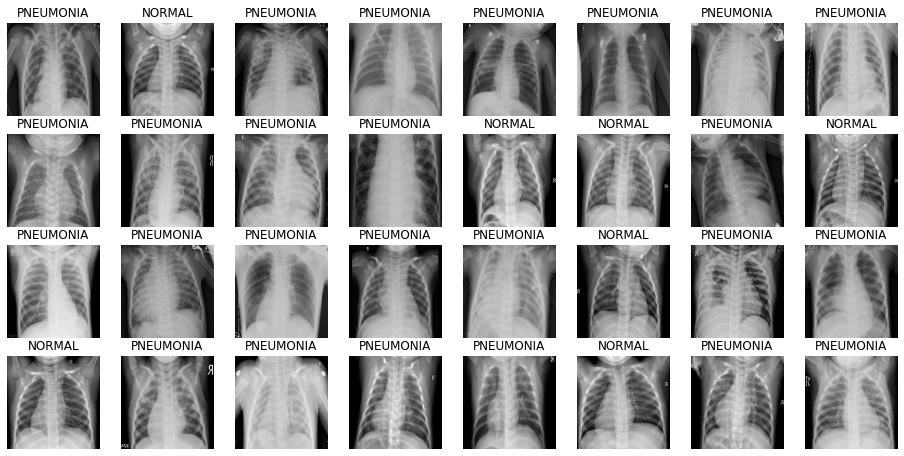

In [36]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. ResNet-18 구현
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

이번 스텝에서는 ResNet-18 구현을 진행합니다. ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.

ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.

우리는 ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

3x3 CNN
BatchNormalization
로 구성되어 있습니다.

위에 있는 그림대로 Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)

In [37]:
def res_block(inputs, filters, strides=1):
    # Shortcut
    shortcut = inputs
    if strides != 1:
        shortcut = tf.keras.layers.Conv2D(filters, 1, strides=strides, padding='same')(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # F(x)
    x = tf.keras.layers.Conv2D(filters, 3, strides=strides, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    # Dropout
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # F(x) + x
    x = tf.keras.layers.add([x, shortcut])
    # Final activation
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

In [38]:
def resnet18():
    input_t = tf.keras.Input(shape=(180, 180, 3))

    # Conv1
    x = tf.keras.layers.Conv2D(64, 7, strides=(2, 2), padding='same')(input_t)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Conv2
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    # Dropout
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x, 64)
    x = res_block(x, 64)
    
    # Conv3
    x = res_block(x, 128, 2)
    x = res_block(x, 128)
    
    # Conv4
    x = res_block(x, 256, 2)
    x = res_block(x, 256)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Conv5
    x = res_block(x, 512, 2)
    x = res_block(x, 512)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_t, outputs=x)
    return model

model = resnet18()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 90, 90, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 90, 90, 64)   256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 90, 90, 64)   0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

# Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

In [39]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [40]:
learning_rates = [0.1, 0.01, 0.001]
optimizers = ['adam', 'sgd', 'rmsprop']

results = {}

for opt in optimizers:
    for lr in learning_rates:
        tf.keras.backend.clear_session()
        with tf.device('/GPU:0'):
            model = resnet18()

            METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]

            if opt == 'adam':
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            elif opt == 'sgd':
                optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            elif opt == 'rmsprop':
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=METRICS
            )

In [41]:
with tf.device('/GPU:0'):
    history = model.fit(
                train_ds,
                steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=val_ds,
                validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                class_weight=class_weight,
            )

Epoch 1/5
130/130 [==============================] - 68s 400ms/step - loss: 0.5359 - accuracy: 0.7437 - precision: 0.7437 - recall: 1.0000 - val_loss: 477.6265 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 52s 399ms/step - loss: 0.2889 - accuracy: 0.7437 - precision: 0.7437 - recall: 1.0000 - val_loss: 37.6509 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 52s 404ms/step - loss: 0.2093 - accuracy: 0.7433 - precision: 0.7433 - recall: 1.0000 - val_loss: 1.0130 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/5
130/130 [==============================] - 54s 417ms/step - loss: 0.1827 - accuracy: 0.7452 - precision: 0.7452 - recall: 1.0000 - val_loss: 0.8894 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/5
130/130 [==============================] - 56s 433ms/step - loss: 0.1429 - accuracy

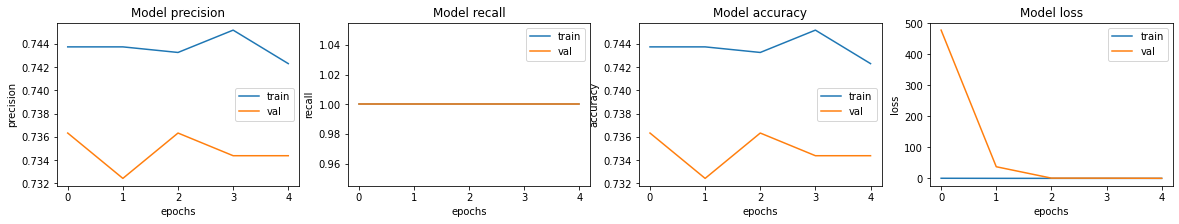

In [43]:
# key = f"{opt}_lr{lr}"
#             results[key] = {
#                 'train_accuracy': history.history['accuracy'],
#                 'val_accuracy': history.history['val_accuracy'],
#                 'train_loss': history.history['loss'],
#                 'val_loss': history.history['val_loss']
#             }
            
# fig, ax = plt.subplots(1, 4, figsize=(20, 3))
# ax = ax.ravel()

# for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
#     ax[i].plot(history.history[met])
#     ax[i].plot(history.history['val_' + met])
#     ax[i].set_title(f'Model {met} ({opt}_lr{lr})')
#     ax[i].set_xlabel('epochs')
#     ax[i].set_ylabel(met)
#     ax[i].legend(['train', 'val'])

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 231ms/step - loss: 1.8795 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.879492163658142,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


# 회고

Learning Rate와 Optimizer를 변경하고 비교해가면서 Acc를 비교해보고 싶었는데 하지못했다, 다음에 기회가 있으면 더 해보고 싶고, Acc가 0.625에서 멈추는 걸로 판단해보건데 overfitting등의 문제가 있는게 아닐까 한다.!